In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import magnetopy as mp

DATA_PATH = Path("../../tests/data/")

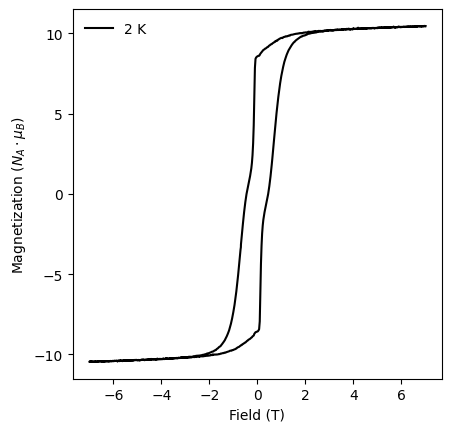

In [2]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
mvsh = dset1.get_mvsh(2)
fig, ax = mvsh.plot()

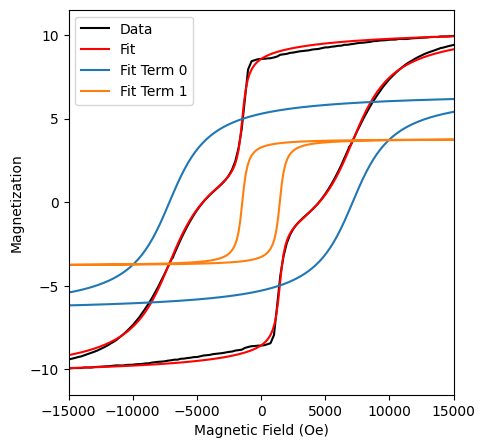

In [3]:
df = mvsh.simplified_data("forward").copy()

cdf_results1 = mp.fit_cauchy_cdf(df['field'], df['moment'], 2)
fig, ax = mp.plot_cauchy(df['field'], df['moment'], "cdf", cdf_results1, True, True, True, True)

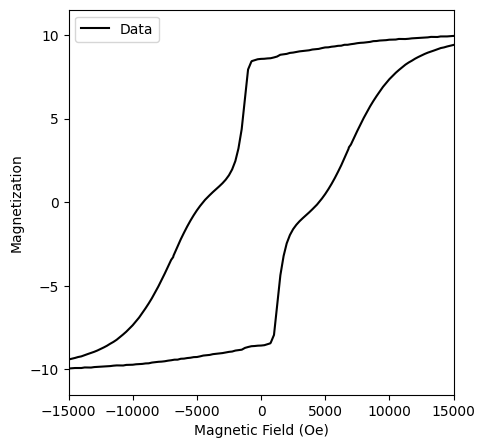

In [4]:
cauchy_cdf1 = mp.CauchyCDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), 2)
fig, ax = cauchy_cdf1.plot()

In [6]:
cauchy_cdf1.results.as_dict()

{'_clas_': 'CauchyAnalysisResults',
 'terms': [{'m_s': 6.610598547123777,
   'm_s_err': 0.05580388232400879,
   'h_c': 7137.957149588925,
   'h_c_err': 35.427350521770364,
   'gamma': 2314.3686488975873,
   'gamma_err': 35.488033882001446},
  {'m_s': 3.7975696757068733,
   'm_s_err': 0.044687186980549465,
   'h_c': 1460.7209273816843,
   'h_c_err': 11.618656040335692,
   'gamma': 320.9722659438162,
   'gamma_err': 15.786066914387193}],
 'chi_pd': 3.3719609901027864e-06,
 'chi_pd_err': 3.5652340244556424e-07,
 'chi_squared': 6.847222126034497,
 'reduced_chi_squared': 0.01231514770869514,
 'm_s_unit': 'unknown',
 'h_c_unit': 'unknown',
 'gamma_unit': 'unknown',
 'chi_pd_unit': 'unknown'}

In [ ]:
df = mvsh.simplified_data("forward").copy()
df['dmdh'] = np.gradient(df['moment'], df['field'])

results1 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], 2)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results1)

In [ ]:
df = mvsh.simplified_data("forward").copy()
df['dmdh'] = np.gradient(df['moment'], df['field'])

results1 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], 2)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results1, False, True)

In [6]:
fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(5, 1000, 2000),
        mp.CauchyParams(8, 7000, 10000),
    ]
)
results2 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], fitting_args)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results2)

KeyError: 'dmdh'

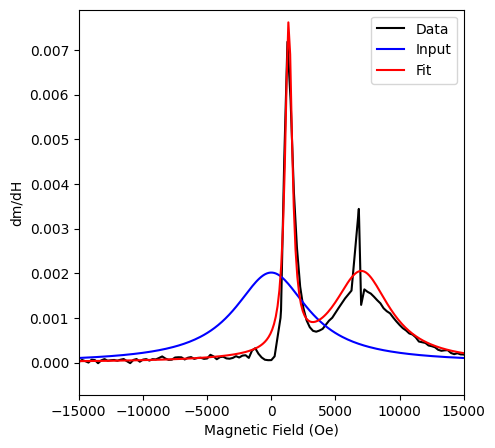

In [7]:
cauchy1 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), 2)
fig, ax = cauchy1.plot(input_params = True)

In [10]:
test = fitting_args.generate_data(np.linspace(-5, 5, 10), "cdf")
type(test)

numpy.ndarray

In [11]:
list(test)

[-4.594306446299831,
 -4.592514622348293,
 -4.5907221295115725,
 -4.5889289679240575,
 -4.587135137721255,
 -4.585340639039783,
 -4.5835454720173825,
 -4.581749636792914,
 -4.579953133506356,
 -4.578155962298815]

In [ ]:
cauchy2 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), fitting_args)
fig, ax = cauchy2.plot(input_params = True)

In [ ]:
cauchy3 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "reverse"), fitting_args)
fig, ax = cauchy3.plot(input_params = True)

In [ ]:
cauchy4 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2), fitting_args)
fig, ax = cauchy4.plot(input_params = True)

In [5]:
cauchy4 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2), fitting_args)
fig, ax = cauchy4.plot(False, True)

NameError: name 'fitting_args' is not defined